<a href="https://colab.research.google.com/github/SADMarketing/dash-sample-apps/blob/main/clusterv2_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
import pandas as pd


df_ = pd.read_excel("/content/Base Cluster  pour Gregory.xlsx")

var_profil = ['Sexe', 'Age', 'TYPOLOGIE', 'Age tranches', 'CSP', 'Habitat',
       'Taille AA', 'Nb voitures du foyer',
       'Nb voitures hybrides ou électriques', 'Revenus mensuels du foyer',
       'CP', 'Insee', 'AA', 'Foyer', 'Enfants au foyer', 'Nb enfants foyer']

var_drop  = ['Sensibilité prix','Sensibilté au temps','Sensibilité ecolo','Sensibilité santé']

df = df_[df_.columns.difference(var_profil+var_drop)]

df = pd.concat([pd.get_dummies(df_[[ 'Sexe', 'Age', 'Age tranches', 'CSP', 'Habitat',
       'Nb voitures du foyer',
       'Nb voitures hybrides ou électriques', 'Revenus mensuels du foyer',
   'Foyer', 'Enfants au foyer', 'Nb enfants foyer']]).iloc[:,2:],df],axis = 1)

In [6]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from scipy.spatial.distance import cdist

sd = StandardScaler()

df = sd.fit_transform(df)


def silhouette_result(df,n_cluster_max):
    warnings.filterwarnings('ignore')
    range_n_clusters = [i for i in range(2,n_cluster_max,1)]
    list_cluster_model = []
    list_cluster = []
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
       # reduc = PCA(n_components=2)
      #  df = reduc.fit_transform(df)
     #   clusterer = KMeans(n_clusters=n_clusters, random_state=10)
      #  cluster_labels = clusterer.fit_predict(df)
        #clusterer = AgglomerativeClustering(n_clusters=n_clusters)
        def my_scorer(estimator, X, y=None):
            X_reduced = estimator.transform(X)
            X_preimage = estimator.inverse_transform(X_reduced)
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)

            cluster_labels = clusterer.fit_predict(X_reduced)
            val = silhouette_score(X_reduced,cluster_labels)
            

            return val
    
        param_grid = [{
            "n_components" : [i for i in range(10,30,2)],
        "gamma": np.linspace(0.03, 1 ,30),
        "kernel": ["rbf", "sigmoid", "poly",'linear']
            }]

        kpca=KernelPCA(fit_inverse_transform=True, n_jobs=-1) 
        grid_search = GridSearchCV(kpca, param_grid, cv=2, scoring=my_scorer)
        grid_search.fit(df)
        df_ = grid_search.transform(df)
    
        df_ = df
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)

           
        cluster_labels = clusterer.fit_predict(df_)
        list_cluster.append(cluster_labels)
        list_cluster_model.append(clusterer) 
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
   
        silhouette_avg = silhouette_score(df_, cluster_labels)
        print(silhouette_avg)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df_, cluster_labels)
        
        visual_reduc = PCA(n_components=2)
        df_visual = visual_reduc.fit_transform(df_)
        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            df_visual[:, 0], df_visual[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )
        centers = clusterer.cluster_centers_
        centers = visual_reduc.transform(centers)
        # Draw white circles at cluster centers
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )
        
        for i, c in enumerate(centers):
           # print(visual_reduc.inverse_transform(c))
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        # Labeling the clusters
   
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()
    
    return list_cluster , list_cluster_model


def plot_kmeans(kmeans, X, n_clusters=15, rseed=0, ax=None):
    labels = kmeans.fit_predict(X )
    
    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=1, alpha=0.2, zorder=1))

        

In [7]:
kmeans = KMeans(n_clusters=15, random_state=0)

kmeans.fit(df)   

KMeans(n_clusters=15, random_state=0)

In [8]:
label = kmeans.fit_predict(df)

In [9]:
df_['label'] = label

In [10]:
df_.to_csv('df_with_label.csv')

In [11]:
df_.to_excel('df_with_label.xlsx')

In [40]:
df_.groupby('label').agg(lambda x : np.mean(x))

,ID,Age,CP,Score prix,Sensibilité prix.1,Je fais très attention à mon budget pour les courses alimentaires,"Je fais très attention à mon budget pour des achats non alimentaires (vêtements, meubles, jouets...)",J’achète très souvent le produit le moins cher,J’ai du mal à boucler mes fins de mois,J’arrive à épargner tous les mois ou presque,...,"Je préfère acheter bio, je pense que c’est meilleur pour la Terre",L’écologie est un critère important dans mes actes d’achat,Sensibilité santé.1,Je préfère consommer moins mais des produits de meilleure qualité,"Je préfère acheter bio, je pense que c’est meilleur pour ma santé",Je fais du sport au moins une fois par semaine,Je consomme régulièrement des fast-foods,Je fume tous les jours et ou je bois de l’alcool plusieurs fois par semaine,J’ai une alimentation équilibrée,Je fais très attention à ma santé
label,,,,,,,,,,,,,,,,,,,,,
0,524.947917,42.875000,51975.812500,11.177083,11.177083,2.020833,2.000000,2.645833,2.760417,2.250000,...,2.437500,2.177083,12.604167,1.854167,2.489583,2.072917,2.791667,3.197917,2.135417,2.041667
1,486.516484,41.219780,59077.406593,12.659341,12.659341,2.263736,2.186813,2.824176,3.219780,1.835165,...,1.923077,1.813187,9.571429,1.428571,1.857143,1.648352,3.351648,3.362637,1.637363,1.714286
2,524.061538,60.830769,48875.438462,12.407692,12.407692,2.300000,2.215385,2.730769,3.192308,2.030769,...,2.730769,2.438462,12.661538,1.923077,2.723077,2.507692,3.515385,3.084615,2.061538,2.046154
3,433.066667,29.333333,48718.000000,7.533333,7.533333,1.533333,1.566667,1.733333,1.866667,3.166667,...,2.633333,2.166667,13.600000,2.133333,2.600000,2.433333,2.766667,2.933333,2.200000,1.933333
4,515.174603,44.142857,57277.944444,10.206349,10.206349,1.904762,1.880952,2.357143,2.547619,2.484127,...,2.515873,2.253968,12.206349,1.857143,2.492063,2.158730,3.007937,3.230159,2.031746,1.904762
5,451.601695,44.152542,57384.644068,12.008475,12.008475,2.271186,2.161017,2.703390,2.949153,2.076271,...,2.872881,2.533898,13.593220,2.177966,2.737288,2.398305,3.033898,3.118644,2.288136,2.144068
6,575.000000,40.750000,44896.250000,10.750000,10.750000,2.250000,1.750000,2.000000,3.000000,2.250000,...,2.750000,2.250000,12.000000,2.000000,2.500000,2.500000,3.000000,4.000000,2.000000,2.000000
7,501.404255,41.255319,54887.787234,10.106383,10.106383,1.829787,1.851064,2.319149,2.638298,2.531915,...,2.680851,2.170213,13.063830,2.063830,2.617021,2.148936,2.702128,3.297872,2.212766,2.021277
8,548.285714,44.714286,59509.857143,8.265306,8.265306,1.551020,1.591837,1.877551,2.020408,2.775510,...,2.489796,2.265306,13.653061,1.979592,2.489796,2.428571,2.755102,2.755102,2.122449,2.142857


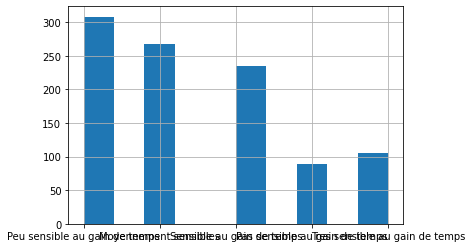

In [45]:
df_['Sensibilté au temps']

In [46]:
df_.columns

Index(['ID', 'Sexe', 'Age', 'TYPOLOGIE', 'Age tranches', 'CSP', 'Habitat',
       'Taille AA', 'Nb voitures du foyer',
       'Nb voitures hybrides ou électriques', 'Revenus mensuels du foyer',
       'CP', 'Insee', 'AA', 'Foyer', 'Enfants au foyer', 'Nb enfants foyer',
       'Score prix', 'Sensibilité prix', 'Sensibilité prix.1',
       'Je fais très attention à mon budget pour les courses alimentaires',
       'Je fais très attention à mon budget pour des achats non alimentaires (vêtements, meubles, jouets...)',
       'J’achète très souvent le produit le moins cher',
       'J’ai du mal à boucler mes fins de mois',
       'J’arrive à épargner tous les mois ou presque', 'Sensibilté au temps',
       'Sensible au temps',
       'J’aime passer du temps sur internet à chercher le produit que je veux m’acheter',
       'Je fais des recherches internet pour gagner du temps en magasin',
       'Je préfère le drive ou la livraison vs l’hypermarché supermarché, c’est plus rapide',
       'J

In [52]:
# etude profil stat descriptif 

var_profil = ['Sexe', 'Age', 'TYPOLOGIE', 'Age tranches', 'CSP', 'Habitat',
       'Taille AA', 'Nb voitures du foyer',
       'Nb voitures hybrides ou électriques', 'Revenus mensuels du foyer',
       'CP', 'Insee', 'AA', 'Foyer', 'Enfants au foyer', 'Nb enfants foyer']


df_[var_profil][df_['label'] == 0]

,Sexe,Age,TYPOLOGIE,Age tranches,CSP,Habitat,Taille AA,Nb voitures du foyer,Nb voitures hybrides ou électriques,Revenus mensuels du foyer,CP,Insee,AA,Foyer,Enfants au foyer,Nb enfants foyer
2,Une femme,47,Mûr Couple avec 2 enfants ou plus aisé,45-59 ans,"Cadre, profession libérale",En maison,de 50 000 à moins de 75 000 habitants,3 voitures ou +,Aucune voiture hybride ou électrique,3000-4500€,21200,21054,Beaune,4 personnes,Oui,2 enfants
9,Une femme,57,Mûr Couple avec 2 enfants ou plus,45-59 ans,Employé,En maison,de 1 000 000 d’habitants ou plus (hors Paris),2 voitures,Aucune voiture hybride ou électrique,Préfère ne pas répondre / ne sait pas,31370,31454,Toulouse,4 personnes,Oui,2 enfants
12,Un homme,46,Mûr Couple avec 2 enfants ou plus Très aisé,45-59 ans,"Cadre, profession libérale",En maison,de 700 000 à moins de 1 000 000 d’habitants,1 voiture,Aucune voiture hybride ou électrique,4500-6100€,67350,67372,Strasbourg (partie française),4 personnes,Oui,2 enfants
24,Un homme,41,Millenials Couple avec 2 enfants ou plus Rev m...,30-44 ans,Employé,En maison,de 75 000 à moins de 100 000 habitants,2 voitures,1 voiture hybride ou électrique,2300-3000€,51510,51242,Châlons-en-Champagne,4 personnes,Oui,2 enfants
37,Un homme,40,Millenials Couple avec 2 enfants ou plus pauvre,30-44 ans,Ouvrier,En maison,de 50 000 à moins de 75 000 habitants,2 voitures,Aucune voiture hybride ou électrique,1150-1500€,52000,52121,Chaumont,4 personnes,Oui,2 enfants
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,Une femme,54,Mûr Couple avec 2 enfants ou plus Rev moyen,45-59 ans,"Sans activité (invalidité, chômage)",En maison,IDF,1 voiture,Aucune voiture hybride ou électrique,1500-2300€,93600,93005,IDF,4 personnes,Oui,2 enfants
974,Une femme,37,Millenials Couple Rev moyen,30-44 ans,"Cadre, profession libérale",En maison,de 200 000 à moins de 300 000 habitants,2 voitures,Aucune voiture hybride ou électrique,2300-3000€,10800,10343,Troyes,4 personnes,Non,NaN
975,Une femme,32,Millenials Couple avec 2 enfants ou plus aisé,30-44 ans,Employé,En appartement,IDF,1 voiture,Aucune voiture hybride ou électrique,3000-4500€,93190,93046,IDF,4 personnes,Oui,2 enfants
978,Une femme,26,Jeune Couple avec 2 enfants ou plus Rev moyen,18-29 ans,Employé,En maison,de moins de 10 000 habitants,1 voiture,Aucune voiture hybride ou électrique,2300-3000€,41220,41220,Saint-Laurent-Nouan,4 personnes,Oui,2 enfants


In [88]:
df_.drop(['ID', 'CP', 'Insee' ] ,axis = 1)

,Sexe,Age,TYPOLOGIE,Age tranches,CSP,Habitat,Taille AA,Nb voitures du foyer,Nb voitures hybrides ou électriques,Revenus mensuels du foyer,...,Sensibilité santé.1,Je préfère consommer moins mais des produits de meilleure qualité,"Je préfère acheter bio, je pense que c’est meilleur pour ma santé",Je fais du sport au moins une fois par semaine,Je consomme régulièrement des fast-foods,Je fume tous les jours et ou je bois de l’alcool plusieurs fois par semaine,J’ai une alimentation équilibrée,Je fais très attention à ma santé,label,label_compare
0,Une femme,39,Millenials Couple avec 2 enfants ou plus Rev m...,30-44 ans,"Sans activité (invalidité, chômage)",En maison,de 75 000 à moins de 100 000 habitants,1 voiture,Aucune voiture hybride ou électrique,1500-2300€,...,16,4,4,2,2,4,2,2,7,other
1,Un homme,18,Jeune Couple avec 2 enfants ou plus,18-29 ans,"Sans activité (invalidité, chômage)",En appartement,de 150 000 à moins de 200 000 habitants,1 voiture,Aucune voiture hybride ou électrique,Préfère ne pas répondre / ne sait pas,...,16,3,4,1,2,4,3,3,7,other
2,Une femme,47,Mûr Couple avec 2 enfants ou plus aisé,45-59 ans,"Cadre, profession libérale",En maison,de 50 000 à moins de 75 000 habitants,3 voitures ou +,Aucune voiture hybride ou électrique,3000-4500€,...,9,1,1,2,3,4,2,2,0,other
3,Une femme,23,Jeune Couple aisé,18-29 ans,"Cadre, profession libérale",En maison,de 20 000 à moins de 30 000 habitants,2 voitures,Aucune voiture hybride ou électrique,3000-4500€,...,11,1,2,1,2,3,2,2,1,other
4,Un homme,27,Jeune Celibataire Rev moyen,18-29 ans,"Cadre, profession libérale",En appartement,de 1 000 000 d’habitants ou plus (hors Paris),1 voiture,Aucune voiture hybride ou électrique,1500-2300€,...,6,1,1,1,3,4,1,1,1,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,Un homme,29,Jeune Celibataire Rev moyen,18-29 ans,Employé,En appartement,IDF,1 voiture,1 voiture hybride ou électrique,1500-2300€,...,11,1,1,1,1,1,1,1,13,other
1001,Un homme,41,Millenials Couple avec 1 enfant Rev moyen,30-44 ans,Employé,En maison,de 30 000 à moins de 50 000 habitants,2 voitures,Aucune voiture hybride ou électrique,2300-3000€,...,15,3,3,3,3,4,3,2,4,other
1002,Une femme,74,Senior Couple Rev moyen,60-75 ans,Retraité,En maison,de 1 000 000 d’habitants ou plus (hors Paris),2 voitures,Aucune voiture hybride ou électrique,2300-3000€,...,5,1,1,1,4,4,1,1,12,other
1003,Une femme,66,Senior Couple Rev moyen,60-75 ans,Retraité,En maison,de 1 000 000 d’habitants ou plus (hors Paris),1 voiture,Aucune voiture hybride ou électrique,2300-3000€,...,11,1,2,1,4,1,2,2,12,other


In [12]:
import os 
os.mkdir("data analyse cluster")

In [66]:
pd.get_dummies(df_['Age tranches']).mean()

18-29 ans    0.188060
30-44 ans    0.266667
45-59 ans    0.286567
60-75 ans    0.258706
dtype: float64

In [63]:
df_.columns

Index(['ID', 'Sexe', 'Age', 'TYPOLOGIE', 'Age tranches', 'CSP', 'Habitat',
       'Taille AA', 'Nb voitures du foyer',
       'Nb voitures hybrides ou électriques', 'Revenus mensuels du foyer',
       'CP', 'Insee', 'AA', 'Foyer', 'Enfants au foyer', 'Nb enfants foyer',
       'Score prix', 'Sensibilité prix', 'Sensibilité prix.1',
       'Je fais très attention à mon budget pour les courses alimentaires',
       'Je fais très attention à mon budget pour des achats non alimentaires (vêtements, meubles, jouets...)',
       'J’achète très souvent le produit le moins cher',
       'J’ai du mal à boucler mes fins de mois',
       'J’arrive à épargner tous les mois ou presque', 'Sensibilté au temps',
       'Sensible au temps',
       'J’aime passer du temps sur internet à chercher le produit que je veux m’acheter',
       'Je fais des recherches internet pour gagner du temps en magasin',
       'Je préfère le drive ou la livraison vs l’hypermarché supermarché, c’est plus rapide',
       'J

In [13]:
def rapport_clustering(df):

  for c in df.label.unique():
 
    df_compare = pd.get_dummies(df.drop('label' , axis = 1))
    df_compare['label'] = df['label']
    df_compare['label_compare'] = df_compare.label.apply(lambda  x: 'grp' if x ==c else 'other' )

    df_grp = df_compare.drop(['label'], axis = 1 ).groupby('label_compare').agg(lambda x : np.mean(x)).transpose()

    df_grp.to_excel("data analyse cluster/grp_"+str(c)+'.xlsx')

    
  print(df_grp)   


        
      




    
    

In [23]:
def rapport_clustering_(df):

  df_rapport = pd.DataFrame()
  for c in df.label.unique():
 
    df_compare = pd.get_dummies(df.drop('label' , axis = 1))
    df_compare['label'] = df['label']
    df_compare['label_compare'] = df_compare.label.apply(lambda  x: 'grp'+str(c) if x ==c else 'other' )

    df_grp = df_compare.drop(['label'], axis = 1 ).groupby('label_compare').agg(lambda x : np.mean(x)).transpose()

    df_grp.to_excel("data analyse cluster/grp_"+str(c)+'.xlsx')

  return df_grp


,ID,Sexe,Age,TYPOLOGIE,Age tranches,CSP,Habitat,Taille AA,Nb voitures du foyer,Nb voitures hybrides ou électriques,...,Sensibilité santé,Sensibilité santé.1,Je préfère consommer moins mais des produits de meilleure qualité,"Je préfère acheter bio, je pense que c’est meilleur pour ma santé",Je fais du sport au moins une fois par semaine,Je consomme régulièrement des fast-foods,Je fume tous les jours et ou je bois de l’alcool plusieurs fois par semaine,J’ai une alimentation équilibrée,Je fais très attention à ma santé,label
0,1,Une femme,39,Millenials Couple avec 2 enfants ou plus Rev m...,30-44 ans,"Sans activité (invalidité, chômage)",En maison,de 75 000 à moins de 100 000 habitants,1 voiture,Aucune voiture hybride ou électrique,...,Peu sensible à l'écologie,16,4,4,2,2,4,2,2,7
1,2,Un homme,18,Jeune Couple avec 2 enfants ou plus,18-29 ans,"Sans activité (invalidité, chômage)",En appartement,de 150 000 à moins de 200 000 habitants,1 voiture,Aucune voiture hybride ou électrique,...,Peu sensible à l'écologie,16,3,4,1,2,4,3,3,7
2,3,Une femme,47,Mûr Couple avec 2 enfants ou plus aisé,45-59 ans,"Cadre, profession libérale",En maison,de 50 000 à moins de 75 000 habitants,3 voitures ou +,Aucune voiture hybride ou électrique,...,Sensibles à la santé,9,1,1,2,3,4,2,2,0
3,4,Une femme,23,Jeune Couple aisé,18-29 ans,"Cadre, profession libérale",En maison,de 20 000 à moins de 30 000 habitants,2 voitures,Aucune voiture hybride ou électrique,...,Sensibles à la santé,11,1,2,1,2,3,2,2,1
4,5,Un homme,27,Jeune Celibataire Rev moyen,18-29 ans,"Cadre, profession libérale",En appartement,de 1 000 000 d’habitants ou plus (hors Paris),1 voiture,Aucune voiture hybride ou électrique,...,Très attention a sa santé,6,1,1,1,3,4,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,1002,Un homme,29,Jeune Celibataire Rev moyen,18-29 ans,Employé,En appartement,IDF,1 voiture,1 voiture hybride ou électrique,...,Sensibles à la santé,11,1,1,1,1,1,1,1,13
1001,1003,Un homme,41,Millenials Couple avec 1 enfant Rev moyen,30-44 ans,Employé,En maison,de 30 000 à moins de 50 000 habitants,2 voitures,Aucune voiture hybride ou électrique,...,Peu sensible à l'écologie,15,3,3,3,3,4,3,2,4
1002,1004,Une femme,74,Senior Couple Rev moyen,60-75 ans,Retraité,En maison,de 1 000 000 d’habitants ou plus (hors Paris),2 voitures,Aucune voiture hybride ou électrique,...,Très attention a sa santé,5,1,1,1,4,4,1,1,12
1003,1005,Une femme,66,Senior Couple Rev moyen,60-75 ans,Retraité,En maison,de 1 000 000 d’habitants ou plus (hors Paris),1 voiture,Aucune voiture hybride ou électrique,...,Sensibles à la santé,11,1,2,1,4,1,2,2,12


In [24]:
ex = rapport_clustering_(df_.drop(['ID', 'CP', 'Insee' , 'AA'  ] ,axis = 1))

In [26]:
for file in os.listdir()
ex.melt()

,label_compare,value
0,grp6,40.750000
1,grp6,10.750000
2,grp6,10.750000
3,grp6,2.250000
4,grp6,1.750000
...,...,...
377,other,0.252747
378,other,0.115884
379,other,0.269730
380,other,0.239760


In [46]:
df_comp = pd.DataFrame()

for i in os.listdir("./data analyse cluster/"):
  df_comp["Unnamed: 0"] = pd.read_excel("./data analyse cluster/"+i)["Unnamed: 0"]
  concat_df = pd.read_excel("./data analyse cluster/"+i).melt()

  df_comp = df_comp.merge(pd.read_excel("./data analyse cluster/"+i),on = "Unnamed: 0" , how = 'left')

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'other_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In [57]:
df_comp['Global']= df_comp[[i for i in df_comp.columns if 'other' in i]].mean(axis = 1)
df_comp.drop([i for i in df_comp.columns if 'other' in i], axis = 1,  inplace = True)

In [67]:
df_comp.melt(id_vars='Unnamed: 0').to_excel('data_cluster_bi.xlsx')

In [65]:
help(pd.DataFrame.melt)

Help on function melt in module pandas.core.frame:

melt(self, id_vars=None, value_vars=None, var_name=None, value_name='value', col_level: 'Level | None' = None, ignore_index: 'bool' = True) -> 'DataFrame'
    Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.
    
    This function is useful to massage a DataFrame into a format where one
    or more columns are identifier variables (`id_vars`), while all other
    columns, considered measured variables (`value_vars`), are "unpivoted" to
    the row axis, leaving just two non-identifier columns, 'variable' and
    'value'.
    
    Parameters
    ----------
    id_vars : tuple, list, or ndarray, optional
        Column(s) to use as identifier variables.
    value_vars : tuple, list, or ndarray, optional
        Column(s) to unpivot. If not specified, uses all columns that
        are not set as `id_vars`.
    var_name : scalar
        Name to use for the 'variable' column. If None it uses
        ``frame

In [38]:
df_comp

,variable,value,variable,value,variable,value,variable,value,variable,value,...,variable,value,variable,value,variable,value,variable,value,variable,value
0,Unnamed: 0,Age,Unnamed: 0,Age,Unnamed: 0,Age,Unnamed: 0,Age,Unnamed: 0,Age,...,Unnamed: 0,Age,Unnamed: 0,Age,Unnamed: 0,Age,Unnamed: 0,Age,Unnamed: 0,Age
1,Unnamed: 0,Score prix,Unnamed: 0,Score prix,Unnamed: 0,Score prix,Unnamed: 0,Score prix,Unnamed: 0,Score prix,...,Unnamed: 0,Score prix,Unnamed: 0,Score prix,Unnamed: 0,Score prix,Unnamed: 0,Score prix,Unnamed: 0,Score prix
2,Unnamed: 0,Sensibilité prix.1,Unnamed: 0,Sensibilité prix.1,Unnamed: 0,Sensibilité prix.1,Unnamed: 0,Sensibilité prix.1,Unnamed: 0,Sensibilité prix.1,...,Unnamed: 0,Sensibilité prix.1,Unnamed: 0,Sensibilité prix.1,Unnamed: 0,Sensibilité prix.1,Unnamed: 0,Sensibilité prix.1,Unnamed: 0,Sensibilité prix.1
3,Unnamed: 0,Je fais très attention à mon budget pour les c...,Unnamed: 0,Je fais très attention à mon budget pour les c...,Unnamed: 0,Je fais très attention à mon budget pour les c...,Unnamed: 0,Je fais très attention à mon budget pour les c...,Unnamed: 0,Je fais très attention à mon budget pour les c...,...,Unnamed: 0,Je fais très attention à mon budget pour les c...,Unnamed: 0,Je fais très attention à mon budget pour les c...,Unnamed: 0,Je fais très attention à mon budget pour les c...,Unnamed: 0,Je fais très attention à mon budget pour les c...,Unnamed: 0,Je fais très attention à mon budget pour les c...
4,Unnamed: 0,Je fais très attention à mon budget pour des a...,Unnamed: 0,Je fais très attention à mon budget pour des a...,Unnamed: 0,Je fais très attention à mon budget pour des a...,Unnamed: 0,Je fais très attention à mon budget pour des a...,Unnamed: 0,Je fais très attention à mon budget pour des a...,...,Unnamed: 0,Je fais très attention à mon budget pour des a...,Unnamed: 0,Je fais très attention à mon budget pour des a...,Unnamed: 0,Je fais très attention à mon budget pour des a...,Unnamed: 0,Je fais très attention à mon budget pour des a...,Unnamed: 0,Je fais très attention à mon budget pour des a...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,other,0.260394,other,0.257322,other,0.256995,other,0.2469,other,0.253266,...,other,0.25261,other,0.252747,other,0.257426,other,0.257812,other,0.252261
569,other,0.126915,other,0.112971,other,0.11399,other,0.105975,other,0.116583,...,other,0.114823,other,0.115884,other,0.118812,other,0.129464,other,0.115578
570,other,0.285558,other,0.261506,other,0.264249,other,0.263811,other,0.268342,...,other,0.26618,other,0.26973,other,0.261826,other,0.285714,other,0.269347
571,other,0.229759,other,0.243724,other,0.24456,other,0.250282,other,0.241206,...,other,0.242171,other,0.23976,other,0.238724,other,0.22433,other,0.241206
